In [1]:
import os, glob
import torch
import nibabel as nib
import numpy as np
import torch.nn.functional as F

In [2]:
from huggingface_hub import hf_hub_download

# Example: download the checkpoint_final.pth
repo_id = "AnonRes/ResEncL-OpenMind-MAE"  # replace with actual repo name
filename = "checkpoint_final.pth"

checkpoint_path = hf_hub_download(repo_id=repo_id, filename=filename)
print("Downloaded checkpoint:", checkpoint_path)

/home/hd/hd_hd/hd_gu452/miniconda3/envs/nnssl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloaded checkpoint: /home/hd/hd_hd/hd_gu452/.cache/huggingface/hub/models--AnonRes--ResEncL-OpenMind-MAE/snapshots/2fa30f642db8e9b2c04bdfb526582fed86ec5850/checkpoint_final.pth


In [3]:
from nnssl.architectures.architecture_registry import get_res_enc_l
from nnssl.run.load_pretrained_weights import load_pretrained_weights
import torch

# Instantiate model
model = get_res_enc_l(num_input_channels=1, num_output_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Load pretrained weights
load_pretrained_weights(model, checkpoint_path, verbose=True)

################### Loading pretrained weights from file  /home/hd/hd_hd/hd_gu452/.cache/huggingface/hub/models--AnonRes--ResEncL-OpenMind-MAE/snapshots/2fa30f642db8e9b2c04bdfb526582fed86ec5850/checkpoint_final.pth ###################
Below is the list of overlapping blocks in pretrained model and nnUNet architecture:
encoder.stem.convs.0.conv.weight shape torch.Size([32, 1, 3, 3, 3])
encoder.stem.convs.0.conv.bias shape torch.Size([32])
encoder.stem.convs.0.norm.weight shape torch.Size([32])
encoder.stem.convs.0.norm.bias shape torch.Size([32])
encoder.stem.convs.0.all_modules.0.weight shape torch.Size([32, 1, 3, 3, 3])
encoder.stem.convs.0.all_modules.0.bias shape torch.Size([32])
encoder.stem.convs.0.all_modules.1.weight shape torch.Size([32])
encoder.stem.convs.0.all_modules.1.bias shape torch.Size([32])
encoder.stages.0.blocks.0.conv1.conv.weight shape torch.Size([32, 32, 3, 3, 3])
encoder.stages.0.blocks.0.conv1.conv.bias shape torch.Size([32])
encoder.stages.0.blocks.0.conv1.nor

In [4]:
import torch
import torch.nn.functional as F

def torch_resize(x, size, mode="bilinear", align_corners=False):
    """
    Resize a 2D or 3D tensor with edge-padding (replicate), similar to
    skimage.transform.resize(..., mode="edge").

    Parameters
    ----------
    x : torch.Tensor
        Input tensor of shape:
        - 3D: (C, H, W) or (C, D, H, W)
        - 4D: (N, C, H, W)
        - 5D: (N, C, D, H, W)
    size : tuple
        Target spatial size (H, W) or (D, H, W).
    mode : str
        Interpolation mode: "nearest", "bilinear" (2D), "trilinear" (3D).
    align_corners : bool
        Same as in torch.nn.functional.interpolate.

    Returns
    -------
    torch.Tensor
        Resized tensor with edge-padding behavior.
    """
    ndim = x.ndim

    # Ensure batch + channel dimensions
    if ndim == 3:   # (C, H, W)
        x = x.unsqueeze(0)   # -> (N, C, H, W)
    elif ndim == 4 and x.shape[1] != 1 and x.shape[1] != 3:
        # Could be (C, D, H, W), add batch dim
        x = x.unsqueeze(0)   # -> (N, C, D, H, W)

    # Pad if target size is bigger than input
    in_size = x.shape[-len(size):]
    pad_sizes = []
    for in_dim, out_dim in zip(reversed(in_size), reversed(size)):
        pad = max(0, out_dim - in_dim)
        pad_sizes.extend([0, pad])
    if any(pad_sizes):
        x = F.pad(x, pad_sizes, mode="replicate")

    # Interpolate to exact target size
    x = F.interpolate(x, size=size, mode=mode, align_corners=align_corners)

    # Squeeze back if input had no batch
    if ndim == 3 or (ndim == 4 and x.shape[0] == 1):
        x = x.squeeze(0)

    return x

def resample_data_or_seg(
    data: torch.Tensor,
    new_shape: tuple,
    is_seg: bool = False,
    order: int = 3,
    order_z: int = 0,
):
    """
    separate_z=True will resample with order 0 along z
    :param data:
    :param new_shape:
    :param is_seg:
    :param order:
    :param do_separate_z:
    :param order_z: only applies if do_separate_z is True
    :return:
    """
    assert data.ndim == 4, "data must be (c, x, y, z)"
    assert len(new_shape) == data.ndim - 1

    if is_seg:
        resize_fn = torch_resize # This may be inaccurate to the numpy version but not used anyways
    else:
        resize_fn = torch_resize
    dtype_data = data.dtype
    shape = torch.Size(data[0].shape)
    new_shape = torch.Size(new_shape)
    if shape != new_shape:
        data = data.float()
            # print("no separate z, order", order)
        reshaped = []
        for c in range(data.shape[0]):
            reshaped.append(resize_fn(data[c], new_shape)[None])
        reshaped_final_data = torch.stack(reshaped, dim=0)
        return reshaped_final_data.to(dtype_data)
    else:
        # print("no resampling necessary")
        return data

In [5]:
from nnssl.experiment_planning.experiment_planners.default_experiment_planner import ExperimentPlanner
from nnssl.experiment_planning.experiment_planners.plan import ConfigurationPlan, Plan
from nnssl.preprocessing.preprocessors.abstract_preprocessor import Preprocessors
import torch


def get_configuration_plan(
    data_identifier: str = "default",
) -> ConfigurationPlan:

    resampling_data = resample_data_or_seg
    resampling_data_kwargs = {
        "is_seg": False,
        "order": 3,
        "order_z": 0,
    }
    resampling_seg = resample_data_or_seg
    resampling_seg_kwargs = {
        "is_seg": True,
        "order": 1,
        "order_z": 0,
    }
    
    spacing = [1, 1, 1]
    spacing_style = "onemmiso"


    plan = {
        "data_identifier": data_identifier,
        "preprocessor_name": Preprocessors.DEFAULT.value,
        "spacing_style": spacing_style,
        "spacing": spacing,
        "normalization_schemes": ["ZScoreNormalization"],
        "use_mask_for_norm": [False],
        "resampling_fn_data": resampling_data,
        "resampling_fn_data_kwargs": resampling_data_kwargs,
        "resampling_fn_mask": resampling_seg,
        "resampling_fn_mask_kwargs": resampling_seg_kwargs,
    }

    return ConfigurationPlan(**plan)

def get_full_plan():
    target_spacing = torch.Tensor([1, 1, 1])

    max_spacing_axis = torch.argmax(target_spacing)
    remaining_axes = [i for i in list(range(3)) if i != max_spacing_axis]
    transpose_forward = torch.Tensor([max_spacing_axis] + remaining_axes).int()
    transpose_backward = [torch.argwhere(torch.Tensor(transpose_forward) == i)[0][0] for i in range(3)]
    median_spacing = torch.Tensor([1,1,1])[transpose_forward]
    plans = Plan(
        **{
            "dataset_name": None,
            "plans_name": "default_plan",
            "original_median_spacing_after_transp": [float(i) for i in median_spacing],
            "image_reader_writer": None,
            "transpose_forward": [int(i) for i in transpose_forward],
            "transpose_backward": [int(i) for i in transpose_backward],
            "configurations": {"onemmiso": get_configuration_plan()},
            "experiment_planner_used": None,
        }
    )
    return plans
    
plan = get_full_plan()

nnssl_raw is not defined and nnssl_raw can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnssl_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
nnssl_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [6]:
print(plan)

Plan(dataset_name=None, plans_name='default_plan', original_median_spacing_after_transp=[1.0, 1.0, 1.0], image_reader_writer=None, transpose_forward=[0, 1, 2], transpose_backward=[0, 1, 2], configurations={'onemmiso': ConfigurationPlan(data_identifier='default', preprocessor_name='DefaultPreprocessor', spacing_style='onemmiso', normalization_schemes=['ZScoreNormalization'], use_mask_for_norm=[False], resampling_fn_data=<function resample_data_or_seg at 0x145d2b2e0820>, resampling_fn_data_kwargs={'is_seg': False, 'order': 3, 'order_z': 0}, resampling_fn_mask=<function resample_data_or_seg at 0x145d2b2e0820>, resampling_fn_mask_kwargs={'is_seg': True, 'order': 1, 'order_z': 0}, spacing=[1, 1, 1], patch_size=None)}, experiment_planner_used=None)


In [7]:
from nnssl.preprocessing.resampling.default_resampling import compute_new_shape, get_resampling_scheme
from dataclasses import field
from acvl_utils.cropping_and_padding.bounding_boxes import crop_to_bbox, bounding_box_to_slice
from functools import partial


def convert_dtype(image: torch.Tensor, target_dtype) -> torch.Tensor:
    return image.to(target_dtype)

def z_score_normalization(
    image: torch.Tensor, use_mask_for_norm: bool, non_zero_mask: torch.Tensor, target_dtype
) -> torch.Tensor:
    image = convert_dtype(image, target_dtype)
    if use_mask_for_norm:
        mask = non_zero_mask >= 0
        mean = image[mask].mean()
        std = image[mask].std()
        image[mask] = (image[mask] - mean) / max(std, 1e-8)
    else:
        mean = image.mean()
        std = image.std()
        image = (image - mean) / max(std, 1e-8)
    return image

def normalize_torch(
    data: torch.Tensor,
    non_zero_mask: torch.Tensor,
    normalization_schemes: list[str],
    use_mask_for_norm: list[bool],
):
    # iterate over images
    for c in range(data.shape[0]):
        if normalization_schemes[c] == "ZScoreNormalization":
            data[c] = z_score_normalization(data[c], use_mask_for_norm[c], non_zero_mask[c], data.dtype)
        else:
            raise(NotImplementedError())
    return data

from acvl_utils.cropping_and_padding.bounding_boxes import crop_to_bbox, bounding_box_to_slice


import torch
import torch.nn.functional as F

def create_nonzero_mask_torch(data: torch.Tensor) -> torch.Tensor:
    """
    Create a mask that is True where the data is nonzero, and fills small holes.

    Args:
        data (torch.Tensor): Input tensor of shape (C, X, Y, Z) or (C, X, Y).
    
    Returns:
        torch.Tensor: Boolean mask of shape (X, Y, Z) or (X, Y).
    """
    assert data.ndim in (3, 4), "data must have shape (C, X, Y, Z) or (C, X, Y)"

    # Collapse channels -> OR across channels
    nonzero_mask = (data != 0).any(dim=0)

    # Fill holes: morphological closing (dilation then erosion)
    # Works for both 2D and 3D
    dims = nonzero_mask.ndim
    if dims == 2:  # (X, Y)
        kernel = torch.ones((1, 1, 3, 3), device=data.device, dtype=torch.float32)
        mask = nonzero_mask[None, None].float()
        dilated = (F.conv2d(mask, kernel, padding=1) > 0).float()
        closed = (F.conv2d(dilated, kernel, padding=1) == 9).squeeze(0).squeeze(0).bool()
    elif dims == 3:  # (X, Y, Z)
        kernel = torch.ones((1, 1, 3, 3, 3), device=data.device, dtype=torch.float32)
        mask = nonzero_mask[None, None].float()
        dilated = (F.conv3d(mask, kernel, padding=1) > 0).float()
        closed = (F.conv3d(dilated, kernel, padding=1) == 27).squeeze(0).squeeze(0).bool()
    else:
        raise ValueError("Unsupported dimensions")

    return closed

def get_bbox_from_mask(mask: torch.Tensor) -> list[list[int]]:
    """
    ALL bounding boxes in acvl_utils and nnU-Netv2 are half open interval [start, end)!
    - Alignment with Python Slicing
    - Ease of Subdivision
    - Consistency in Multi-Dimensional Arrays
    - Precedent in Computer Graphics
    https://chatgpt.com/share/679203ec-3fbc-8013-a003-13a7adfb1e73

    this implementation uses less ram than the np.where one and is faster as well IF we expect the bounding box to
    be close to the image size. If it's not it's likely slower!

    :param mask:
    :param outside_value:
    :return:
    """
    Z, X, Y = mask.shape
    minzidx, maxzidx, minxidx, maxxidx, minyidx, maxyidx = 0, Z, 0, X, 0, Y
    zidx = list(range(Z))
    for z in zidx:
        if torch.any(mask[z]):
            minzidx = z
            break
    for z in zidx[::-1]:
        if torch.any(mask[z]):
            maxzidx = z + 1
            break

    xidx = list(range(X))
    for x in xidx:
        if torch.any(mask[:, x]):
            minxidx = x
            break
    for x in xidx[::-1]:
        if torch.any(mask[:, x]):
            maxxidx = x + 1
            break

    yidx = list(range(Y))
    for y in yidx:
        if torch.any(mask[:, :, y]):
            minyidx = y
            break
    for y in yidx[::-1]:
        if torch.any(mask[:, :, y]):
            maxyidx = y + 1
            break
    return [[minzidx, maxzidx], [minxidx, maxxidx], [minyidx, maxyidx]]



def crop_to_nonzero(data, masks: list[torch.Tensor] | None = None, nonzero_label=-1):
    """

    :param data:
    :param seg:
    :param nonzero_label: this will be written into the segmentation map
    :return:
    """
    nonzero_mask = create_nonzero_mask_torch(data)
    bbox = get_bbox_from_mask(nonzero_mask)

    slicer = bounding_box_to_slice(bbox)
    data = data[tuple([slice(None), *slicer])]
    nonzero_mask = nonzero_mask[slicer][None]

    slicer = (slice(None),) + slicer
    if masks is not None and len(masks) > 0:
        for cnt, mask in enumerate(masks):
            masks[cnt] = mask[slicer]
            masks[cnt][(masks[cnt] == 0) & (~nonzero_mask)] = nonzero_label

    else:
        masks = [torch.where(nonzero_mask, torch.zeros(1).int(), int(nonzero_label))]
    return data, masks, bbox

def preprocess_case(
    data,
    masks=None,
    plan = get_full_plan(),
    properties=None,
    verbose: bool = False,
):
    # let's not mess up the inputs!
    data = data.clone()
    if masks is not None:
        for mask in masks:
            assert (
                data.shape[1:] == mask.shape[1:]
            ), "Shape mismatch between image and associated masks. Please fix your dataset and make use of the --verify_dataset_integrity flag to ensure everything is correct"
        masks = [mask.clone() for mask in masks]

    has_masks = masks is not None

    # apply transpose_forward, this also needs to be applied to the spacing!
    data = data.permute([0, *[i + 1 for i in plan.transpose_forward]])
    if has_masks:
        for cnt, mask in enumerate(masks):
            masks[cnt] = mask.transpose([0, *[i + 1 for i in plan.transpose_forward]])
    original_spacing = [properties["spacing"][i] for i in plan.transpose_forward]

    # crop, remember to store size before cropping!
    shape_before_cropping = data.shape[1:]
    properties["shape_before_cropping"] = shape_before_cropping
    # this command will generate a segmentation. This is important because of the nonzero mask which we may need
    data, masks, bbox = crop_to_nonzero(data, masks)
    properties["bbox_used_for_cropping"] = bbox
    properties["shape_after_cropping_and_before_resampling"] = data.shape[1:]

    config_plan = plan["configurations"]["onemmiso"]
    # resample
    target_spacing = config_plan.spacing  # this should already be transposed

    if len(target_spacing) < len(data.shape[1:]):
        # target spacing for 2d has 2 entries but the data and original_spacing have three because everything is 3d
        # in 2d configuration we do not change the spacing between slices
        target_spacing = [original_spacing[0]] + target_spacing
    new_shape = compute_new_shape(data.shape[1:], original_spacing, target_spacing)

    # normalize
    # normalization MUST happen before resampling or we get huge problems with resampled nonzero masks no
    # longer fitting the images perfectly!
    norm_mask = masks[0]
    data = normalize_torch(data, norm_mask, config_plan.normalization_schemes, config_plan.use_mask_for_norm)
    old_shape = data.shape[1:]
    resampling_fn = partial(
        config_plan.resampling_fn_data, **config_plan.resampling_fn_data_kwargs
    )
    data = resampling_fn(data, new_shape)

    if has_masks:
        resampling_mask_fn = partial(
            config_plan.resampling_fn_mask, **config_plan.resampling_fn_mask_kwargs
        )
        for cnt, mask in enumerate(masks):
            masks[cnt] = resampling_mask_fn(mask, new_shape)
    if verbose:
        print(
            f"old shape: {old_shape}, new_shape: {new_shape}, old_spacing: {original_spacing}, "
            f"new_spacing: {target_spacing}, fn_data: {config_plan.resampling_fn_data}"
        )
    if not has_masks:
        masks = None
    return data, masks

In [12]:
import nibabel as nib
import torch.nn.functional as F

nii_path = "/home/hd/hd_hd/hd_gu452/FFF_fiberlearning/notebooks/monai_models/openmind_diffusion_training/predictions/unet_3d_seed50851_size128x256x256_spacing1.25x1.00x1.00_20250929120942_rank0.nii.gz"

def load_nii_as_tensor(path, target_shape=(96, 96, 96)):
    """
    Load a NIfTI file, normalize intensity, and resize to target shape.
    Returns: torch.FloatTensor of shape (1, 1, D, H, W).
    """
    img = nib.load(path).get_fdata()

    tensor = torch.from_numpy(img).unsqueeze(0)  # (1,1,D,H,W)

    data_properties = {
        "spacing": [1, 1, 1],
    }
    
    data, mask = preprocess_case(tensor, properties=data_properties)
    data = data.unsqueeze(0)
    # resize to model input shape
    if target_shape is not None:
        data = F.interpolate(data, size=target_shape, mode="trilinear", align_corners=False)
    return data.float().to(device)


x = load_nii_as_tensor(nii_path)

In [13]:
with torch.no_grad():
    output = model(x)

# example: get embeddings (flatten)
embedding = output.view(-1).cpu().numpy()

# save embedding as .npy
base = os.path.basename(nii_path).replace(".nii.gz", "")

print(f"Processed {nii_path}, embedding shape: {embedding.shape}")

Processed /home/hd/hd_hd/hd_gu452/FFF_fiberlearning/notebooks/monai_models/openmind_diffusion_training/predictions/unet_3d_seed50851_size128x256x256_spacing1.25x1.00x1.00_20250929120942_rank0.nii.gz, embedding shape: (884736,)


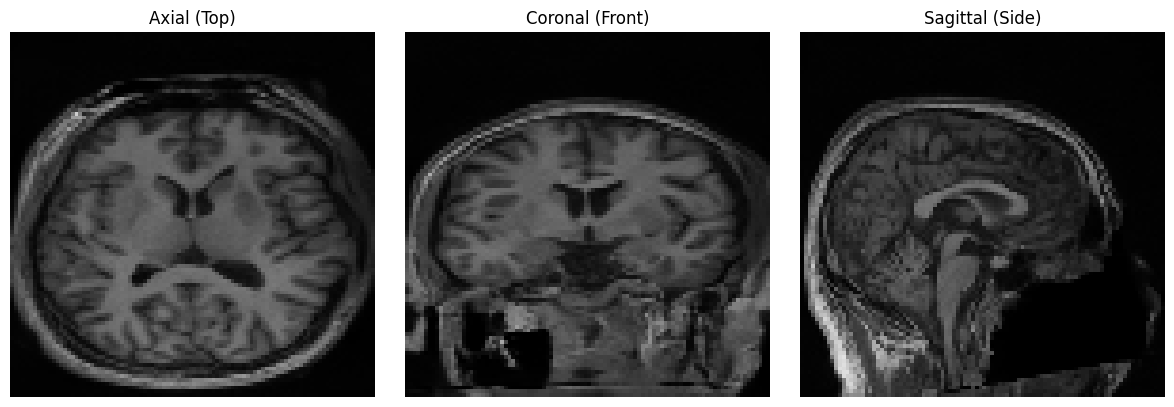

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_orthogonal_views(volume):
    """
    Show axial (top), coronal (front), and sagittal (side) views
    from the center of a 3D MRI volume.

    Args:
        volume: 3D array-like (H, W, D) or 4D (C, H, W, D).
    """
    # Ensure numpy
    if isinstance(volume, torch.Tensor):
        volume = volume.detach().cpu().numpy()
    if volume.ndim == 4:  # remove channel if present
        volume = volume[0]

    # Shape: (H, W, D)
    h, w, d = volume.shape

    # Extract central slices
    axial = volume[:, :, d // 2]     # top view
    coronal = volume[:, w // 2, :]   # front view
    sagittal = volume[h // 2, :, :]  # side view

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(axial.T, cmap="gray", origin="lower", vmin=0, vmax=1)
    axes[0].set_title("Axial (Top)")
    axes[0].axis("off")

    axes[1].imshow(coronal.T, cmap="gray", origin="lower", vmin=0, vmax=1)
    axes[1].set_title("Coronal (Front)")
    axes[1].axis("off")

    axes[2].imshow(sagittal.T, cmap="gray", origin="lower", vmin=0, vmax=1)
    axes[2].set_title("Sagittal (Side)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


x_norm = (x - x.min())/(x.max() - x.min())
visualize_orthogonal_views(x_norm.squeeze())